In [7]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, mmread
import sys
import itertools 
import pickle
import matplotlib.pylab as plt
import time

In [6]:
%matplotlib inline

In [8]:
import rankingmethod
import rankingmeasure

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
from  experiment import *

# loading data sets

In [11]:
data = pd.read_csv("../datasets/soc-Epinions1.txt", sep='\t', header=4)
data = data.as_matrix()

In [12]:
epinion, epinion_shape = make_valid_data(data)

In [14]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [15]:
slashdot, slashdot_shape = make_valid_data(data)

In [16]:
data =  pd.read_csv("../datasets/ml-100k/u.data", sep='\t', header=None).ix[:, :1]
data = data.as_matrix()

In [17]:
ml100k, ml100k_shape = make_valid_data(data)

In [18]:
data = pd.read_csv("../datasets/ml-1m/ratings.dat", sep='::', header=None,  engine='python').ix[:, :1]
data = data.as_matrix()

In [19]:
ml1m, ml1m_shape = make_valid_data(data)

### Узнаем статистические данные о датасетам.

In [65]:
def statistics_of_data(matrix):
    num_nonzero = matrix.shape[0]
    num_user = np.unique(matrix[:, 0]).shape[0]
    num_items = np.unique(matrix[:, 1]).shape[0]
    sparsity = num_nonzero / (num_user * num_items) * 100
    mean_items = np.mean(np.bincount(matrix[:, 0]))
    median_items = np.median(np.bincount(matrix[:, 0]))
    max_items = np.max(np.bincount(matrix[:, 0]))
    return (num_nonzero, num_user, num_items, sparsity, mean_items, median_items, max_items)

In [66]:
print("epinion", statistics_of_data(epinion))
print("slashdot", statistics_of_data(slashdot))
print("ml100k", statistics_of_data(ml100k))
print("ml1m", statistics_of_data(ml1m))

epinion (326114, 4405, 34777, 0.21287831073657335, 74.032690124858121, 51.0, 1801)
slashdot (573578, 6992, 63730, 0.12872033080059936, 82.033466819221971, 50.0, 2508)
ml100k (96963, 806, 1682, 7.152288277868424, 120.3014888337469, 81.0, 737)
ml1m (989202, 5549, 3702, 4.815416389070059, 178.26671472337358, 106.0, 2314)


### Зададим параметры, которые были выбраны при помощивалидации

In [193]:
def create_list_cf(user_item, index=[0,1,2,3,4]):
    list_cf = [
        rankingmethod.PopRec(user_item),
        rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
        rankingmethod.BPR_MF(user_item, K = 20, lrate=0.012, regIpos=0.012, 
                                  regIneg=0.012, regU=0.012, maxiter=4, verbose=0 ),
        rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
        rankingmethod.TFMAP(user_item, lrate=0.01, maxiter=10)   
    ]
    return [list_cf[i] for i in index]

### Проведение такого же эксперимента, как у создатей CLiMF(Точнее похожего, т.к. было решено не удалять топ 3 всех предметов. И даже с этим удалением получить такие же цифры, что авторы epinion не получилось)

In [24]:
def climf_experiment(data, list_cf, K=5, maxiter=1, topK=5, verbose=0, validation_type=0):
    res = np.zeros((6, len(list_cf)))
    for t in range(maxiter):
        if validation_type == 0:
            train, test, traintest = givenK_train_test(data, K)
        elif validation_type == 1:
            train, test, traintest = ratio_train_test(data, K)
        for i, cf in enumerate(list_cf):
            cf.fit(train)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, cf, K=topK)
            mrr, auc = rankingmeasure.get_listmetrics(train, test, cf)
            res[:, i] += np.array([prec_k, one_recal_k, ngdc, mp, mrr, auc])
            if verbose == 1:
                print(t, i, res[:, i] / (t + 1))
                sys.stdout.flush()
    res /= maxiter
    res = pd.DataFrame(res)
    res.columns = ['PopRec', 'CLiMF', 'BRP_MP', 'iMF', 'TFMAP']
    res.index = ['prec@' + str(topK),'1recal@' + str(topK), 'NDCG@' + str(topK), 
               'MAP@' + str(topK), 'MRR', 'AUC']
    return res

In [12]:
climf_experiment(epinion, create_list_cf(epinion_shape), K =5, maxiter=1, topK=5,  verbose=1)

0 0 [ 0.19872872  0.56322361  0.22223028  0.3813747   0.43876484  0.83078188]
0 1 [ 0.19627696  0.54483541  0.22058629  0.37696557  0.43686134  0.751281  ]
0 2 [ 0.19609535  0.54506243  0.22056008  0.37749779  0.43836972  0.83474024]
0 3 [ 0.1876958   0.55096481  0.19806486  0.33561389  0.3818591   0.69152973]
0 4 [ 0.18074915  0.54483541  0.21043037  0.38731271  0.43067057  0.64071455]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.198729,0.196277,0.196095,0.187696,0.180749
1recal@5,0.563224,0.544835,0.545062,0.550965,0.544835
NDCG@5,0.222230,0.220586,0.220560,0.198065,0.210430
MAP@5,0.381375,0.376966,0.377498,0.335614,0.387313
MRR,0.438765,0.436861,0.438370,0.381859,0.430671
AUC,0.830782,0.751281,0.834740,0.691530,0.640715


In [13]:
climf_experiment(epinion, create_list_cf(epinion_shape), K =10, maxiter=1, topK=5,  verbose=1)

0 0 [ 0.18374574  0.51895573  0.20614182  0.35681423  0.41139733  0.85585377]
0 1 [ 0.18442679  0.52939841  0.20641345  0.35726227  0.41128224  0.8143902 ]
0 2 [ 0.1846538   0.52417707  0.19095555  0.31205732  0.34803992  0.85916652]
0 3 [ 0.26138479  0.63836549  0.27257366  0.41211344  0.46091017  0.81057056]
0 4 [ 0.18083995  0.52122588  0.20414805  0.35973704  0.41143295  0.73103908]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.183746,0.184427,0.184654,0.261385,0.180840
1recal@5,0.518956,0.529398,0.524177,0.638365,0.521226
NDCG@5,0.206142,0.206413,0.190956,0.272574,0.204148
MAP@5,0.356814,0.357262,0.312057,0.412113,0.359737
MRR,0.411397,0.411282,0.348040,0.460910,0.411433
AUC,0.855854,0.814390,0.859167,0.810571,0.731039


In [60]:
climf_experiment(slashdot, create_list_cf(slashdot_shape), K =5, maxiter=1, topK=5,  verbose=0)

0 0 [ 0.12251144  0.37657323  0.1319391   0.22953991  0.27654298  0.77703793]
0 1 [ 0.12274027  0.37743135  0.13169759  0.22891141  0.27554472  0.68970927]
0 2 [ 0.12105263  0.37614416  0.1309013   0.22970379  0.27613604  0.78503591]
0 3 [ 0.10494851  0.34196224  0.10975562  0.1949623   0.23434489  0.59086203]
0 4 [ 0.11538902  0.35926773  0.12445819  0.21948119  0.25677406  0.59737827]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.122511,0.122740,0.121053,0.104949,0.115389
1recal@5,0.376573,0.377431,0.376144,0.341962,0.359268
NDCG@5,0.131939,0.131698,0.130901,0.109756,0.124458
MAP@5,0.229540,0.228911,0.229704,0.194962,0.219481
MRR,0.276543,0.275545,0.276136,0.234345,0.256774
AUC,0.777038,0.689709,0.785036,0.590862,0.597378


In [61]:
climf_experiment(slashdot, create_list_cf(slashdot_shape), K=10, maxiter=1, topK=5,  verbose=0)

0 0 [ 0.11192792  0.35283181  0.12102636  0.2146759   0.26020113  0.81278055]
0 1 [ 0.11189931  0.35283181  0.12100122  0.21473311  0.2598129   0.75821488]
0 2 [ 0.11284325  0.35311785  0.1207925   0.21107714  0.25587895  0.81823682]
0 3 [ 0.13584096  0.39287757  0.1424579   0.23748272  0.27949474  0.69255127]
0 4 [ 0.11281465  0.35440503  0.121591    0.21485865  0.25942938  0.66626014]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.111928,0.111899,0.112843,0.135841,0.112815
1recal@5,0.352832,0.352832,0.353118,0.392878,0.354405
NDCG@5,0.121026,0.121001,0.120793,0.142458,0.121591
MAP@5,0.214676,0.214733,0.211077,0.237483,0.214859
MRR,0.260201,0.259813,0.255879,0.279495,0.259429
AUC,0.812781,0.758215,0.818237,0.692551,0.666260


In [76]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K=5, maxiter=5, topK=5,  verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.530918,0.513151,0.530323,0.462531,0.262481
1recal@5,0.943176,0.933499,0.937469,0.897022,0.746154
NDCG@5,0.534166,0.517198,0.531936,0.475641,0.305572
MAP@5,0.670363,0.651275,0.663692,0.634136,0.545234
MRR,0.704501,0.697036,0.701981,0.681804,0.593101
AUC,0.827417,0.757246,0.828865,0.678551,0.636698


In [26]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K=0.3, maxiter=1, topK=5,  verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.490074,0.481638,0.471216,0.545409,0.454342
1recal@5,0.823821,0.924318,0.929280,0.945409,0.825062
NDCG@5,0.516571,0.495152,0.468724,0.551071,0.483134
MAP@5,0.650408,0.651920,0.622279,0.686011,0.639506
MRR,0.715253,0.718661,0.633890,0.729202,0.696904
AUC,0.853390,0.839363,0.861575,0.900622,0.830759


In [23]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K=5, maxiter=1, topK=5,  verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.519851,0.522581,0.518610,0.473449,0.106700
1recal@5,0.923077,0.908189,0.923077,0.916873,0.428040
NDCG@5,0.545489,0.545383,0.544996,0.490104,0.133978
MAP@5,0.703162,0.688505,0.696381,0.659590,0.304797
MRR,0.758824,0.752578,0.759222,0.703923,0.360647
AUC,0.824477,0.756184,0.826532,0.679469,0.641628


In [109]:
climf_experiment(ml100k, create_list_cf(ml100k_shape), K=15, maxiter=5, topK=5,  verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.484119,0.482184,0.473846,0.530720,0.473846
1recal@5,0.914640,0.914144,0.907444,0.929280,0.893797
NDCG@5,0.493463,0.495831,0.472595,0.536979,0.480281
MAP@5,0.649267,0.656846,0.611769,0.674191,0.621278
MRR,0.688521,0.698497,0.647435,0.713904,0.666023
AUC,0.853098,0.840584,0.853146,0.828562,0.763474


In [111]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=5, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.480555,0.483583,0.479762,0.473995,0.413840
1recal@5,0.880519,0.870427,0.882682,0.870788,0.853848
NDCG@5,0.493571,0.495208,0.492313,0.485062,0.451584
MAP@5,0.648909,0.653467,0.648408,0.628551,0.662639
MRR,0.694116,0.691678,0.693038,0.672882,0.701911
AUC,0.850340,0.828613,0.848813,0.718570,0.747666


In [107]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=10, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.490395,0.490395,0.483583,0.573905,0.490611
1recal@5,0.861056,0.861056,0.847901,0.930258,0.858713
NDCG@5,0.501165,0.501165,0.491860,0.583821,0.501419
MAP@5,0.655779,0.655779,0.615115,0.708827,0.659461
MRR,0.690318,0.690345,0.659755,0.753014,0.689735
AUC,0.856129,0.851473,0.855643,0.827976,0.804301


In [27]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=6, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.500703,0.498757,0.496486,0.498216,0.492125
1recal@5,0.880699,0.880339,0.875113,0.894035,0.871869
NDCG@5,0.514340,0.512994,0.511246,0.509248,0.494660
MAP@5,0.676980,0.673792,0.680485,0.650624,0.606999
MRR,0.710236,0.710129,0.708744,0.695986,0.640935
AUC,0.852317,0.837624,0.850562,0.749077,0.763947


In [28]:
climf_experiment(ml1m, create_list_cf(ml1m_shape), K=7, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP
prec@5,0.479798,0.480771,0.485241,0.513246,0.458966
1recal@5,0.878356,0.878356,0.874752,0.903766,0.873311
NDCG@5,0.498165,0.498785,0.501551,0.523188,0.479777
MAP@5,0.660597,0.661752,0.663838,0.661806,0.646317
MRR,0.703256,0.702981,0.702257,0.704798,0.701442
AUC,0.853562,0.841434,0.851802,0.769942,0.776398


In [ ]:
for i in range(5, 16, 5):
    res = climf_experiment(epinion, create_list_cf(epinion_shape), K = i, topK=5)
    with open( respath + '_climfexperiment_' + 'epinion' + str(i) +'.pickle', 'wb') as f:
        pickle.dump(res, f)
    print(res)
    sys.stdout.flush()

In [ ]:
for i in range(5, 16, 5):
    res = climf_experiment(slashdot, create_list_cf(slashdot_shape),K = i, topK=5)
    with open( respath + '_climfexperiment_' + 'slashdot' + str(i) +'.pickle', 'wb') as f:
        pickle.dump(res, f)
    print(res)
    sys.stdout.flush()

In [ ]:
# for i in range(5, 21, 5):
#     with open('climf_res' + str(i) +'.pickle', 'rb') as f:
#         tbl = pickle.load(f)
#     print('---------')
#     print('K =', i)
#     show_smart_table(tbl)
#     with open('climf_res_top' + str(i) + '.pickle', 'rb') as f:
#         tbl = pickle.load(f)
#     print('---------')
#     print('K =', i, 'without top')
#     show_smart_table(tbl)

### Сравнение работы методов(на наборе данных epinion). В данный момент мне кажется, что данныйэксперимент не совсем коректен

In [82]:
import rankensemble
from scipy import stats
ens = rankensemble.ensemble(create_list_cf(ml100k_shape), verbose=1)

train, test, traintest = givenK_train_test(ml100k, 5)

In [88]:
ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [91]:
for i in range(1, 5):
    print(stats.describe(ens.list_cf[i].get_f(0)).minmax)

(0.00011912396926166499, 0.0009642097462448071)
(-0.018065161852567208, 1.137419421615514)
(-0.58646263422899936, 0.84246634378077601)
(0.00016782302882083043, 0.0012646633346597746)


In [80]:
z = ens.list_cf[2].get_f(0)

In [81]:
z

156.92485978817024

In [67]:
stats.describe([1,2,3,4,5])

DescribeResult(nobs=5, minmax=(1, 5), mean=3.0, variance=2.5, skewness=0.0, kurtosis=-1.3)

In [88]:
mean_matrix_similar(ens, topK=5)

array([[ 0.        ,  0.80068104,  0.99350738,  0.15718502,  0.96286039],
       [ 0.80068104,  0.        ,  0.80485812,  0.15582293,  0.80190692],
       [ 0.99350738,  0.80485812,  0.        ,  0.15741203,  0.95750284],
       [ 0.15718502,  0.15582293,  0.15741203,  0.        ,  0.15723042],
       [ 0.96286039,  0.80190692,  0.95750284,  0.15723042,  0.        ]])

In [89]:
mean_matrix_similar(ens, topK=10)

array([[ 0.        ,  0.90338252,  0.99920545,  0.18208854,  0.64785471],
       [ 0.90338252,  0.        ,  0.9030874 ,  0.18256527,  0.67334847],
       [ 0.99920545,  0.9030874 ,  0.        ,  0.18213394,  0.64735528],
       [ 0.18208854,  0.18256527,  0.18213394,  0.        ,  0.17053348],
       [ 0.64785471,  0.67334847,  0.64735528,  0.17053348,  0.        ]])

### Построение ансамбля

In [118]:
import rankensemble

In [45]:
def ensemble_experiment(data, list_cf, list_ensemble, K=5, maxiter=1, topK=5, verbose=0):
    res = np.zeros((4, len(list_cf) + len(list_ensemble)))
    for t in range(maxiter):
        train, test, traintest = givenK_train_test(data, K)
        for i in range(len(list_cf)):
            list_cf[i].fit(train)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, list_cf[i], K=topK)
            res[:, i] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t, i, res[:, i] / (t + 1))
                sys.stdout.flush()
            
        for j, ens in enumerate(list_ensemble):
            m = j + len(list_cf)
            ens.fit(list_cf)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, ens, K=topK)
            res[:, m] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t, m, res[:, m] / (t +1))
        
    res /= maxiter
    res = pd.DataFrame(res)
    res.columns = [type(cf).__name__ for cf in list_cf] + [type(ens).__name__ for ens  in list_ensemble]
    res.index = [name + str(topK) for name in ['prec@', '1recal@', 'NDCG@', 'MAP@']]
#     res.index = []
#     res.columns = ['PopRec', 'CLiMF', 'BRP_MP', 'iMF', 'TFMAP', 'top_ensemble', 'rating_ensamble']
#     res.index = ['prec@' + str(topK),'1recal@' + str(topK), 'NDCG@' + str(topK), 
#                'MAP@' + str(topK)]
    return res

In [42]:
type(create_list_cf(ml100k_shape)[1]).__name__

'CLiMF'

In [44]:
create_list_cf(ml100k_shape)[1].__class__.__name__

'CLiMF'

In [126]:
list_ensemble = [
    rankensemble.top_ensemble(topK=100),
    rankensemble.rating_ensemble()
]

In [157]:
ensemble_experiment(ml100k, create_list_cf(ml100k_shape), list_ensemble, K=5, maxiter=1, topK=5, verbose=1)

0 0 [ 0.54168734  0.9516129   0.56554854  0.73091915]
0 1 [ 0.53523573  0.94789082  0.56062876  0.72182417]
0 2 [ 0.53002481  0.94665012  0.54791251  0.71001344]
0 3 [ 0.47047146  0.9057072   0.48534118  0.64311759]
0 4 [ 0.28684864  0.80645161  0.35644954  0.6578698 ]
0 5 [ 0.49181141  0.94665012  0.52469951  0.71084746]
0 6 [ 0.51960298  0.95409429  0.55077109  0.73050041]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.541687,0.535236,0.530025,0.470471,0.286849,0.491811,0.519603
1recal@5,0.951613,0.947891,0.946650,0.905707,0.806452,0.946650,0.954094
NDCG@5,0.565549,0.560629,0.547913,0.485341,0.356450,0.524700,0.550771
MAP@5,0.730919,0.721824,0.710013,0.643118,0.657870,0.710847,0.730500


In [162]:
ensemble_experiment(ml100k, create_list_cf(ml100k_shape), list_ensemble, K=5, maxiter=5, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.531216,0.494541,0.530174,0.473449,0.175831,0.424814,0.471861
1recal@5,0.937717,0.933251,0.936973,0.900744,0.595037,0.892308,0.920596
NDCG@5,0.529777,0.504456,0.528797,0.487309,0.205168,0.437663,0.486816
MAP@5,0.661718,0.658123,0.663150,0.642809,0.400903,0.602600,0.651020


In [134]:
ensemble_experiment(epinion, create_list_cf(epinion_shape), list_ensemble, K=5, maxiter=1, topK=5, verbose=0)

,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.200772,0.200817,0.200863,0.185108,0.173984,0.208445,0.208808
1recal@5,0.567537,0.567764,0.567991,0.547333,0.535074,0.607037,0.602951
NDCG@5,0.226087,0.225243,0.226201,0.194972,0.192173,0.229174,0.232720
MAP@5,0.393387,0.390337,0.393568,0.330410,0.345052,0.397119,0.403010


In [133]:
ensemble_experiment(epinion, create_list_cf(epinion_shape), list_ensemble, K=10, maxiter=1, topK=5, verbose=0)

0 0 [ 0.18342792  0.51509648  0.20601151  0.3564737 ]
0 1 [ 0.18410897  0.51577753  0.20671154  0.35824001]
0 2 [ 0.18270148  0.51055619  0.20579179  0.35790989]
0 3 [ 0.25357548  0.63813848  0.2618443   0.39858147]
0 4 [ 0.17934166  0.5107832   0.20290152  0.3545671 ]
0 5 [ 0.22860386  0.62860386  0.24676022  0.40783485]
0 6 [ 0.21262202  0.60090806  0.22739217  0.3751586 ]


,PopRec,CLiMF,BRP_MP,iMF,TFMAP,top_ensemble,rating_ensamble
prec@5,0.183428,0.184109,0.182701,0.253575,0.179342,0.228604,0.212622
1recal@5,0.515096,0.515778,0.510556,0.638138,0.510783,0.628604,0.600908
NDCG@5,0.206012,0.206712,0.205792,0.261844,0.202902,0.246760,0.227392
MAP@5,0.356474,0.358240,0.357910,0.398581,0.354567,0.407835,0.375159


In [136]:
np.random.choice(5, 5, replace=False)

array([1, 4, 0, 3, 2])

In [150]:
import random
a = [1,2,3,4,5]
print(random.shuffle(a), a)

None [5, 1, 3, 2, 4]


## ансамбль по внутренним значениям функции

In [92]:
import rankensemble
ens = rankensemble.ensemble(create_list_cf(ml100k_shape)[1:], verbose=1)
train, test, traintest = givenK_train_test(ml100k, 5)

In [99]:
list_ensemble = [
    rankensemble.top_ensemble(topK=100),
    rankensemble.rating_ensemble(), 
    rankensemble.inner_value_ensemble()
]

In [100]:
ensemble_experiment(ml100k, create_list_cf(ml100k_shape)[1:5], list_ensemble, K=5, verbose=0, maxiter=5)

[ 0.25  0.25  0.25  0.25] 4
[ 0.25  0.25  0.25  0.25] 4
[ 0.25  0.25  0.25  0.25] 4
[ 0.25  0.25  0.25  0.25] 4
[ 0.25  0.25  0.25  0.25] 4
[ 0.25  0.25  0.25  0.25] 4
[ 0.25  0.25  0.25  0.25] 4
[ 0.25  0.25  0.25  0.25] 4


,CLiMF,BPR_MF,iMF,TFMAP,top_ensemble,rating_ensemble,inner_value_ensemble
prec@5,0.512109,0.525558,0.472655,0.177618,0.419305,0.446799,0.536774
1recal@5,0.932010,0.937469,0.893052,0.569231,0.902233,0.916129,0.943176
NDCG@5,0.523862,0.530794,0.486806,0.201704,0.433299,0.471194,0.546477
MAP@5,0.675033,0.671971,0.640342,0.379078,0.609188,0.656207,0.686571


In [101]:
ensemble_experiment(epinion, create_list_cf(epinion_shape)[1:5], list_ensemble, K=5, verbose=0, maxiter=1)

,CLiMF,BPR_MF,iMF,TFMAP,top_ensemble,rating_ensemble,inner_value_ensemble
prec@5,0.180431,0.188014,0.184109,0.173258,0.200454,0.201453,0.214938
1recal@5,0.517594,0.538252,0.543473,0.523723,0.577299,0.575709,0.595687
NDCG@5,0.205617,0.214008,0.194805,0.204222,0.224405,0.225677,0.237588
MAP@5,0.365572,0.376399,0.331701,0.379403,0.392286,0.390641,0.400422


In [110]:
ensemble_experiment(slashdot, create_list_cf(slashdot_shape)[1:5], list_ensemble, K=5, verbose=0, maxiter=1)

,CLiMF,BPR_MF,iMF,TFMAP,top_ensemble,rating_ensemble,inner_value_ensemble
prec@5,0.121968,0.122855,0.101459,0.119737,0.120938,0.123656,0.125114
1recal@5,0.377860,0.378432,0.332380,0.372283,0.378576,0.380578,0.386728
NDCG@5,0.130784,0.131439,0.107111,0.127627,0.129354,0.131958,0.133357
MAP@5,0.227373,0.227325,0.194135,0.221557,0.228266,0.229514,0.231118


In [111]:
ensemble_experiment(ml1m, create_list_cf(ml1m_shape)[1:5], list_ensemble, K=5, verbose=0, maxiter=1)

,CLiMF,BPR_MF,iMF,TFMAP,top_ensemble,rating_ensemble,inner_value_ensemble
prec@5,0.504559,0.505244,0.485132,0.490359,0.518364,0.514615,0.520851
1recal@5,0.875113,0.874572,0.888809,0.876374,0.905749,0.895657,0.891152
NDCG@5,0.517085,0.515328,0.499976,0.498633,0.527513,0.525717,0.542030
MAP@5,0.682962,0.677821,0.647709,0.629691,0.672084,0.680369,0.699213


In [115]:
list_ensemble = [
    rankensemble.inner_value_ensemble(weights=np.array([1,1, 10, 1]))
]

In [116]:
ensemble_experiment(epinion, create_list_cf(epinion_shape)[1:5], list_ensemble, K=10, verbose=0, maxiter=1)

,CLiMF,BPR_MF,iMF,TFMAP,inner_value_ensemble
prec@5,0.182747,0.182747,0.258797,0.183519,0.269330
1recal@5,0.525766,0.526220,0.651759,0.524858,0.672872
NDCG@5,0.206053,0.206053,0.270489,0.206387,0.281737
MAP@5,0.361180,0.361931,0.416956,0.359116,0.434343


In [117]:
ensemble_experiment(slashdot, create_list_cf(slashdot_shape)[1:5], list_ensemble, K=10, verbose=0, maxiter=1)

,CLiMF,BPR_MF,iMF,TFMAP,inner_value_ensemble
prec@5,0.112300,0.112386,0.135870,0.111299,0.141991
1recal@5,0.353976,0.354691,0.404891,0.367277,0.426344
NDCG@5,0.121223,0.121207,0.142725,0.120212,0.149601
MAP@5,0.214589,0.214217,0.242934,0.218668,0.256233


In [118]:
ensemble_experiment(ml1m, create_list_cf(ml1m_shape)[1:5], list_ensemble, K=10, verbose=0, maxiter=1)

,CLiMF,BPR_MF,iMF,TFMAP,inner_value_ensemble
prec@5,0.476626,0.473491,0.576644,0.476518,0.603028
1recal@5,0.866823,0.866462,0.930798,0.859254,0.942512
NDCG@5,0.490535,0.488713,0.589394,0.489458,0.617823
MAP@5,0.646142,0.647062,0.717732,0.641655,0.744346


In [140]:
### взвешенные средние внутренних функций способно превосходить даже iMF,
### когда она работает на порядок лучше, чем другие методы. это не может не радовать.
# Попробую реализовать все методы, которые я нашел от чудо пдфки победителей конкурса Netflix

# Netflix ensemble
# Regression

In [104]:
from sklearn import cross_validation

In [105]:
def netflix_ensemble_experiment(data, list_cf, list_ensemble, Ktrain=5, Kvalidation=5, 
                                     maxiter=1, topK=5,  verbose=0):
    res = np.zeros((4, len(list_cf) + len(list_ensemble)))
    for t in range(maxiter):
        train, test, traintest = givenK_train_test(data, Ktrain + Kvalidation)
        train, validation, trainvalidation = givenK_train_test(train, Ktrain, data_is_xlist=True)
        
        for i in range(len(list_cf)):
            list_cf[i].fit(train)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(trainvalidation, test, list_cf[i], K=topK)
            res[:, i] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t, i, res[:, i] / (t + 1))
                sys.stdout.flush()
            
        for j, ens in enumerate(list_ensemble):
            m = j + len(list_cf)
            ens.fit(list_cf, validation, train, trainvalidation)
            prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(trainvalidation, test, ens, K=topK)
            res[:, m] += np.array([prec_k, one_recal_k, ngdc, mp])
            if verbose == 1:
                print(t,  m, res[:, m] / (t + 1))
#         for j, ens in enumerate(list_ensemble):
#             m = j + len(list_cf)
#             ens.fit(list_cf)
#             prec_k, one_recal_k, ngdc, mp = rankingmeasure.get_Kmetrics(train, test, ens, K=topK)
#             res[:, m] += np.array([prec_k, one_recal_k, ngdc, mp])
#             if verbose == 1:
#                 print(t, m, res[:, m] / (t +1))
        
    res /= maxiter
    res = pd.DataFrame(res)
    res.columns = [type(cf).__name__ for cf in list_cf] + [type(ens).__name__ for ens  in list_ensemble]
    res.index = [name + str(topK) for name in ['prec@', '1recal@', 'NDCG@', 'MAP@']]
#     res.index = []
#     res.columns = ['PopRec', 'CLiMF', 'BRP_MP', 'iMF', 'TFMAP', 'top_ensemble', 'rating_ensamble']
#     res.index = ['prec@' + str(topK),'1recal@' + str(topK), 'NDCG@' + str(topK), 
#                'MAP@' + str(topK)]
    return res

In [107]:
from sklearn import linear_model
import rankensemble
from sklearn import ensemble
from sklearn.kernel_ridge import KernelRidge

In [31]:
import copy

In [180]:
weights = np.array([[alpha, 1 - alpha] for alpha in np.linspace(0, 1, 11)])
print(weights)

[[ 0.   1. ]
 [ 0.1  0.9]
 [ 0.2  0.8]
 [ 0.3  0.7]
 [ 0.4  0.6]
 [ 0.5  0.5]
 [ 0.6  0.4]
 [ 0.7  0.3]
 [ 0.8  0.2]
 [ 0.9  0.1]
 [ 1.   0. ]]


In [204]:
list_ensemble = [
#     rankensemble.boost_val_ens(rankingmeasure.get_NDCG, index = [0,1,2,3], num_weights=51),
#     rankensemble.boost_val_ens(rankingmeasure.get_NDCG, index = [1,2,3, 0], num_weights=51),
#     rankensemble.boost_val_ens(rankingmeasure.get_NDCG, index = [2,3,0,1], num_weights=51),
    rankensemble.boost_val_ens(rankingmeasure.get_NDCG, index = [3,0,1,2], num_weights=51),
    
    rankensemble.tree_val_ens(rankingmeasure.get_NDCG, index = [[0,1], [2, 3]]),
    rankensemble.tree_val_ens(rankingmeasure.get_NDCG, index = [[0,2], [1, 3]]),
    rankensemble.tree_val_ens(rankingmeasure.get_NDCG, index = [[0,3], [1, 2]])
    
#     rankensemble.boost_val_ens(rankingmeasure.get_NDCG, num_weights=51),
#     rankensemble.boost_val_ens(rankingmeasure.get_NDCG, num_weights=51),
#     rankensemble.boost_val_ens(rankingmeasure.get_NDCG, num_weights=51),
#     rankensemble.boost_val_ens(rankingmeasure.get_NDCG, num_weights=51)
    
#     rankensemble.val_ens(weights, rankingmeasure.get_NDCG, verbose=1),
#     rankensemble.val_ens(weights, rankingmeasure.get_MAP, verbose=1),
#     rankensemble.val_ens(weights, rankingmeasure.get_prec_K, verbose=1),
#     rankensemble.val_ens(weights, rankingmeasure.get_one_recal_K, verbose=1)
#     rankensemble.regression_ensemble(KernelRidge(), ratio_neg=2),
#     rankensemble.regression_ensemble(linear_model.RANSACRegressor()),
#     rankensemble.regression_ensemble(linear_model.Ridge(alpha=0.01)),
#     rankensemble.regression_ensemble(linear_model.Ridge(alpha=0.01, fit_intercept=False)),
#     rankensemble.regression_ensemble(linear_model.Ridge(alpha=1)),
#     rankensemble.regression_ensemble(linear_model.Ridge(alpha=100)),
#     rankensemble.regression_ensemble(linear_model.Ridge(alpha=100))
#     rankensemble.regression_ensemble(linear_model.LogisticRegression(C = 1),ratio_neg=40, verbose=1),
#     rankensemble.regression_ensemble(linear_model.LogisticRegression(C = 0.00001), verbose=1),
#     rankensemble.regression_ensemble(linear_model.LogisticRegression(C = 10000), verbose=1),
]

In [ ]:
netflix_ensemble_experiment(ml100k, create_list_cf(ml100k_shape)[1:5], list_ensemble, Ktrain=5, Kvalidation=5, verbose=1, maxiter=5)

0 0 [ 0.50496278  0.94416873  0.52077296  0.69091019]
0 1 [ 0.51265509  0.94168734  0.53936848  0.71851048]
0 2 [ 0.45955335  0.88709677  0.47464298  0.63366419]
0 3 [ 0.29751861  0.80521092  0.34587881  0.59352943]


In [ ]:
np.

In [142]:
netflix_ensemble_experiment(ml100k, create_list_cf(ml100k_shape)[1:5], list_ensemble, Ktrain=5, Kvalidation=5, verbose=1)

0 0 [ 0.53573201  0.9292804   0.53788757  0.66626689]
0 1 [ 0.52059553  0.93796526  0.53949659  0.69389475]
0 2 [ 0.45756824  0.89454094  0.47104081  0.62657672]
0 3 [ 0.15781638  0.51612903  0.17338857  0.32216019]
0 4 [ 0.54367246  0.94044665  0.56529187  0.71492969]
0 5 [ 0.52034739  0.94044665  0.53900884  0.69508375]
0 6 [ 0.52630273  0.94292804  0.54733211  0.70572787]


,CLiMF,BPR_MF,iMF,TFMAP,regression_ensemble,regression_ensemble,regression_ensemble
prec@5,0.535732,0.520596,0.457568,0.157816,0.543672,0.520347,0.526303
1recal@5,0.929280,0.937965,0.894541,0.516129,0.940447,0.940447,0.942928
NDCG@5,0.537888,0.539497,0.471041,0.173389,0.565292,0.539009,0.547332
MAP@5,0.666267,0.693895,0.626577,0.322160,0.714930,0.695084,0.705728


In [ ]:
netflix_ensemble_experiment(slashdot, create_list_cf(slashdot_shape)[1:5], 
                            list_ensemble, Ktrain=5, Kvalidation=5, verbose=1)

In [ ]:
netflix_ensemble_experiment(ml1m, create_list_cf(ml1m_shape)[1:5], list_ensemble, 
                            Ktrain=5, Kvalidation=5, verbose=1)

In [45]:
train, test, traintest = givenK_train_test(ml100k, 5)

In [50]:
aaa = create_list_cf(ml100k_shape)[1:5]

In [51]:
aaa[1].fit(train)
aaa[2].fit(train)

In [55]:
toprank = aaa[2].get_list(0)
toprank[1:10]

array([514, 209, 227, 196,  78,   6, 420, 658, 208])

In [75]:

print(f[209])
above_item = []
for u in range(ml100k_shape[0]):
    f = aaa[1].get_f(u)
    toprank = aaa[2].get_list(u)
    above_item.append(np.sum(f > f[toprank[-15]]))

0.619945541564


In [76]:
np.mean(above_item)

253.4727047146402

In [85]:
t1 = np.random.rand(10)
t2 = np.random.rand(10)

In [34]:
t1

array([ 0.78114513,  0.4146638 ,  0.8523995 ,  0.90663462,  0.05827786,
        0.70974532,  0.43612249,  0.59249669,  0.59577544,  0.17374118])

In [42]:
i = 2
print(alpha[i] * t1 + (1 - alpha[i]) * t2)

[ 0.27240136  0.25204509  0.47267031  0.26953897  0.27240136  0.6885786
  0.54045922  0.69683014  0.51915752  0.22162313]


In [160]:
a = [1, 2, 3]
b = np.array([4,5])

a.extend((b))
print(a)

[1, 2, 3, 4, 5]


In [161]:
np.isnan(np.nan)

True

In [141]:
def find_alpha(a1, a2, index = None):
    if index is None:
        all_pairs = np.transpose([np.tile(a1, a2.shape[0]), np.tile(a2, a1.shape[0]), 
                      np.repeat(a1, a2.shape[0]), np.repeat(a2, a1.shape[0])])
    else:
        all_pairs = np.transpose([np.tile(a1[index], a2.shape[0]), np.tile(a2[index], a1.shape[0]), 
                      np.repeat(a1, len(index)), np.repeat(a2, len(index))])
    print(all_pairs.shape, all_pairs)
    alpha = (- all_pairs[:, 1]  + all_pairs[:, 3]) / (all_pairs[:, 0] - all_pairs[:, 1] - all_pairs[:, 2]  + all_pairs[:, 3])
    alpha = alpha[np.logical_not(np.isnan(alpha))]
    alpha = alpha[alpha > 0 ]
    alpha = alpha[alpha < 1]
    return np.unique(alpha)

In [143]:
t1 = np.array([1,2, 3, 4, 5])
t2 = np.array([1,3,5,4,2])

In [151]:
alpha = find_alpha(t1, t2)

(25, 4) [[1 1 1 1]
 [2 3 1 1]
 [3 5 1 1]
 [4 4 1 1]
 [5 2 1 1]
 [1 1 2 3]
 [2 3 2 3]
 [3 5 2 3]
 [4 4 2 3]
 [5 2 2 3]
 [1 1 3 5]
 [2 3 3 5]
 [3 5 3 5]
 [4 4 3 5]
 [5 2 3 5]
 [1 1 4 4]
 [2 3 4 4]
 [3 5 4 4]
 [4 4 4 4]
 [5 2 4 4]
 [1 1 5 2]
 [2 3 5 2]
 [3 5 5 2]
 [4 4 5 2]
 [5 2 5 2]]


In [152]:
alpha

array([ 0.25      ,  0.5       ,  0.6       ,  0.66666667])

In [153]:
i = 0.66666667
t1 * i + t2 * (1 - i)

array([ 1.        ,  2.33333333,  3.66666666,  4.        ,  4.00000001])

In [102]:
np.sort(alpha)

array([ 0.5])

In [101]:
netflix_ensemble_experiment(epinion, create_list_cf(epinion_shape)[1:5], list_ensemble, Ktrain=5, Kvalidation=5, verbose=1)

NameError: name 'netflix_ensemble_experiment' is not defined

In [90]:
a = np.arange(4 * 5).reshape(4, 5).astype(float)
a += 1
print(a)
a  /=  np.max(a , axis=0)[np.newaxis, :]
print(a)

[[  1.   2.   3.   4.   5.]
 [  6.   7.   8.   9.  10.]
 [ 11.  12.  13.  14.  15.]
 [ 16.  17.  18.  19.  20.]]
[[ 0.0625      0.11764706  0.16666667  0.21052632  0.25      ]
 [ 0.375       0.41176471  0.44444444  0.47368421  0.5       ]
 [ 0.6875      0.70588235  0.72222222  0.73684211  0.75      ]
 [ 1.          1.          1.          1.          1.        ]]


In [86]:
np.max(a , axis=0)

array([16, 17, 18, 19, 20])

In [25]:
create_list_cf

NameError: name 'list_cf' is not defined

In [ ]:
givenK_train_test()

In [139]:
kf = cross_validation.KFold(n=10, n_folds=2, shuffle=True,
                               random_state=None)

for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 2 4 7 9] TEST: [1 3 5 6 8]
TRAIN: [1 3 5 6 8] TEST: [0 2 4 7 9]


In [ ]:
def rank_cross_validation(train, test, train_index, test_index):
    x_train = [train[i] for i in train_index]
    x_test = [train[i] for i in test_index]
    
    y_train = [test[i] for i in train_index]
    y_test = [test[i] for i in test_index]
    
    return X_train, X_test, y_train, y_test

## Старые некрасивые эксперименты

### проверка работы ансамбля givenk = 5

In [34]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.20889898,  0.59659478,  0.23334799,  0.40400019])

In [36]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.19704881  0.55913734  0.22254752  0.38464813]
[ 0.1938252   0.56118048  0.22009766  0.38748802]
[ 0.19523269  0.56072645  0.22107609  0.38591121]
[ 0.17711691  0.52485812  0.18861426  0.32164586]
[ 0.18719637  0.55323496  0.21465356  0.38445958]


In [37]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 10)

array([ 0.17402951,  0.72122588,  0.20026969,  0.37375175])

In [38]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 10))

[ 0.16944381  0.68876277  0.19412473  0.35670129]
[ 0.16989784  0.68944381  0.19419015  0.3561263 ]
[ 0.16955732  0.69057889  0.19406199  0.35569465]
[ 0.15768445  0.67309875  0.17098093  0.31099781]
[ 0.15738933  0.65788876  0.18414103  0.35370021]


### проверка работы ансамбля givenk = 10 iMF слишком хорошо работает(

In [59]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.24281498,  0.676958  ,  0.26581623,  0.44658374])

In [60]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.18320091  0.53416572  0.20701312  0.36450404]
[ 0.1815664   0.53870602  0.20560403  0.36648253]
[ 0.18292849  0.53348468  0.20675077  0.36393303]
[ 0.26115778  0.71577753  0.28306775  0.47061798]
[ 0.17257662  0.51577753  0.19827725  0.35810853]


In [44]:
import time
t = time.time()
a = top_ens.get_list(0, 4000)
print(time.time() - t)

0.31627511978149414


In [97]:
a =np.arange(6*3).reshape(6, 3)
print(a)
print(a.ravel())
print(a.T.ravel())

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  3  6  9 12 15  1  4  7 10 13 16  2  5  8 11 14 17]


In [57]:
ansamble.show_all_ulist(5, 10)

PopRec [  18  721 1042  674  143  118  711  136   34 1536]
CLiMF [  18  674  721 1042 1536  118  143  711  136   34]
BPR_MF [  18 1042  721  674  143  118 1536  136   34  711]
iMF [497 362 378  43   1 379  10  12  79 125]
TFMAP [  18  674 1042  721  711   28  143 3805   34   77]


In [119]:
import copy
import sys
class rating_ensemble:
    def __init__(self, list_cf, weights = None, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
        if weights is None:
            self.weights = np.ones(len(list_cf))/len(list_cf)
        else:
            assert(weights.shape[0] == len(list_cf))
            self.weights = weights
        self.N_items = self.list_cf[1].N_items
        self.N_methods = len(self.list_cf)
        #self.index = np.arange(self.N_items)[::-1] + 1
        self.index = np.exp(-0.5 * np.arange(self.N_items))
        
    def get_list(self, u):
        res = np.zeros(self.N_items)
        for i in range(self.N_methods):
            ranks = self.list_cf[i].get_list(u)
            res[ranks] += self.weights[i] * self.index 
        return np.argsort(-res)
    

### givenK = 5

In [95]:
train5, test5, traintest5 = givenK_train_test(epinion, 5)

In [97]:
ens5 = ensemble(list_cf, verbose=1)
ens5.fit(train5)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [98]:
rating_ens = rating_ensemble(ens5.list_cf)

In [102]:
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20340522,  0.57207719,  0.21539089,  0.35614769])

In [103]:
for cf in rating_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train5, test5, cf, True, K = 5))

[ 0.19723042  0.5523269   0.22281641  0.38555146]
[ 0.19673099  0.55005675  0.22215417  0.38491046]
[ 0.1953689   0.55005675  0.22130483  0.38498266]
[ 0.17734393  0.53461975  0.18653377  0.31993852]
[ 0.18696935  0.54801362  0.21227095  0.37798714]


In [120]:
rating_ens = rating_ensemble(ens5.list_cf)
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20281498,  0.57707151,  0.22675051,  0.39048966])

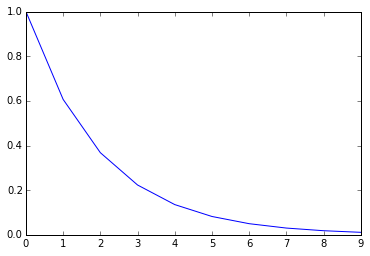

In [117]:
plt.plot(np.exp(-0.5 * np.arange(10)))

In [64]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

In [65]:
a

array([4, 4, 2, 2, 8, 7, 1, 2, 0, 6])

In [67]:
np.argsort(-a)

array([4, 5, 9, 0, 1, 2, 3, 7, 6, 8])

In [ ]:
np.argosrt()

In [61]:
a = None

In [63]:
if a is None:
    print("ywe")

ywe


# Slashdot data set

In [127]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [128]:
data.shape

(905467, 2)

In [129]:
slashdot, user_item = make_valid_data(data)

In [155]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
    rankingmethod.TFMAP(user_item, reg=0.001, lrate=0.01, maxiter=12)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [132]:
train, test, traintest = givenK_train_test(slashdot, 5)

In [133]:
poprec = rankingmethod.PopRec(user_item_slash)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.122225400458
1-call5 0.37528604118993136
MRR 0.273406086512
AUC 0.776325504811
NGDC 0.131158605935
MAP 0.227184043669


### givenk = 5

In [138]:
slash_ens = ensemble(list_cf, verbose=1)

In [139]:
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [140]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.1222254   0.37528604  0.13115861  0.22718404]
[ 0.12233982  0.37585812  0.13122573  0.22734037]
[ 0.12268307  0.37585812  0.1314579   0.227249  ]
[ 0.10420481  0.33495423  0.10975777  0.19563589]
[ 0.12062357  0.37628719  0.12923841  0.22546283]


In [141]:
top_ens = top_ensemble(slash_ens.list_cf, topK=100)

In [142]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.12402746,  0.39487986,  0.13112244,  0.23042843])

### givenk = 10

In [156]:
train, test, traintest = givenK_train_test(slashdot, 10)

In [157]:
slash_ens = ensemble(list_cf, verbose=1)
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [158]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
#all_measures(train, test, poprec, True, top)
rankingmeasure.get_Kmetrics(train, test, poprec, True, K=5)

array([ 0.10918192,  0.3506865 ,  0.11928689,  0.21512741])

In [159]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10943936  0.35054348  0.11506516  0.2026143 ]
[ 0.13667048  0.40789474  0.14297494  0.24199681]
[ 0.10918192  0.3506865   0.11928901  0.21513456]


### Сравнение глазками

In [162]:
for cf in slash_ens.list_cf:
    print(type(cf).__name__)
    print(cf.get_list(0)[:15])

PopRec
[4668  394 2481  225 8848 4690 5043 3443  377  217 5390   34 2470 3444   46]
CLiMF
[4668  394 2481  225 8848 4690 5043 3443  377 5390   34  217 2470   46 2539]
BPR_MF
[ 394 2481 4668  225 8848  217 4690  377 5043 3443   46 5390 2470   34  403]
iMF
[2481 4668  143  151  205   15 4845   59 3369 3947 4979  186  400 5367 3083]
TFMAP
[4668  394 2481  225 8848 4690 5043 3443  377 3444  403  217 5390 5705 7450]


In [150]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.15946796,  0.51001144,  0.16663805,  0.29156159])

# старые эксперименты

In [ ]:
a = np.arange(10)
b = a[1:4]
print(a)
print(b)
b[2] = 100
a[1] = -a[1]
print(a)
print(b)

In [ ]:
tmp = mmread("../datasets/epinions_original/EP25_UPL5_test.mtx")
test = np.array(list(zip(tmp.row, tmp.col)))
tmp = mmread("../datasets/epinions_original/EP25_UPL5_train.mtx")
train = np.array(list(zip(tmp.row, tmp.col)))
user_item = [max(np.max(test[:,0]), np.max(train[:, 0])) + 1, max(np.max(test[:,1]), np.max(train[:,1])) + 1]

In [ ]:
train = create_listarray(train)
test  = create_listarray(test)

In [ ]:
create_csr(train, user_item, '../pyCLiMF-master/good_train.pickle')
create_csr(test, user_item, '../pyCLiMF-master/good_test.pickle')

In [ ]:
randomrec = rankingmethod.RandomRec(user_item)
randomrec.fit(train)
all_measures(train, test, randomrec, False)

In [ ]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
# all_measures(train, test, poprec, True)

In [ ]:
rankingmeasure.get_AUC(train, test, poprec, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 5)

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 3)

In [ ]:
index_user = np.random.choice(len(train), 100, replace=False)


In [ ]:
orig_train = create_original_sample(train, index_user)
orig_test = create_original_sample(test, index_user)

In [ ]:
climf = rankingmethod.CLiMF(user_item, lrate = 0.0001, reg=0.001, maxiter=15, verbose=2)
climf.fit(train)

In [ ]:
rankingmeasure.get_MRR(train, test, climf, True)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
all_measures(train, test, climf, True)

In [ ]:
climf = rankingmethod.CLiMF(user_item, maxiter=40, lrate = 0.1, verbose=2)
climf.fit(train)


In [ ]:
all_measures(train, test, climf, False)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
list_reg = [0.001, 0.002, 0.005, 0.0005]
list_lrate = [0.05, 0.07, 0.1, 0.12, 0.15 ]
list_K = [10, 12, 15, 7, 5]
times_count = 3

for K, lrate, reg in itertools.product(list_K, list_lrate, list_reg):
    MRR = 0
    
    for t in range(times_count):
        climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=50)
        climf.fit(train)
        MRR += rankingmeasure.get_MRR(train, test, climf, skip_train=False)
    print("K", K, "lrate", lrate, "reg", reg, "MRR", MRR/times_count)
    sys.stdout.flush()

In [ ]:
bpr_mf = rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=2 )

In [ ]:
bpr_mf.fit(train)

In [ ]:
all_measures(train, test, bpr_mf, True)

In [ ]:
rankingmeasure.get_AUC(train, test, bpr_mf, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, bpr_mf, True, K=5)

In [ ]:
imf = rankingmethod.iMF(user_item, K=20, lmbd=0.01, alpha=40, maxiter=30, verbose=2)

In [ ]:
imf.fit(train)

In [ ]:
all_measures(train, test, imf, True)

In [ ]:
all_measures(train, test, imf, True, top)

In [ ]:
all_measures(train, test, bpr_mf, True, top)

In [ ]:
all_measures(train, test, poprec, True)

In [ ]:
all_measures(train, test, poprec, True, top)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
a = np.array([False,False, True, True])
b = np.array([0,2,1,3])
print(roc_auc_score(a, b, average=None))

In [ ]:
(a == True).any()

In [ ]:
import random

In [ ]:
random.sample(range(10), 3)